**Assign Train and Test Data**

In [ ]:
import  tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import zipfile

In [ ]:

tf.random.set_seed(42)
print('Tensorflow version',tf.__version__)

Tensorflow version 2.19.0


In [ ]:

# Download DataSet From Kaggle.com
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 93% 152M/163M [00:00<00:00, 1.59GB/s]
100% 163M/163M [00:00<00:00, 1.55GB/s]


In [ ]:
#Unzipping the dataset

with zipfile.ZipFile('face-mask-dataset.zip','r') as zip_ref:
    zip_ref.extractall(".")


In [ ]:
#Checking the folders inside the data directory.

base_dir="data"
print("DataSet Folders: ",os.listdir(base_dir))

DataSet Folders:  ['without_mask', 'with_mask']


In [ ]:
#Training data generator

#Rescales image pixel values from [0,255] to [0,1] (to make training faster and more stable),
#splits the dataset into:
#80% for training (subset='training')
#20% for validation/testing (subset='validation')

datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)


train_data=datagen.flow_from_directory(base_dir,
                                       target_size=(224,224), #Resizes each image to 224×224 pixels
                                       batch_size=32, #Groups them in batches of 32 images
                                       class_mode='binary', #Labels them as 0 (for one folder) and 1 (for the other)
                                       subset='training',
                                       seed=42)



Found 6043 images belonging to 2 classes.


In [ ]:
#Validation/Test data generator

test_data=datagen.flow_from_directory(base_dir,
                                      target_size=(224,224),
                                      batch_size=32,
                                      class_mode='binary',
                                      subset='validation',
                                      seed=42)


Found 1510 images belonging to 2 classes.


**Model CNN**

In [8]:
model=tf.keras.models.Sequential([
    #creates 16 filters (small feature detectors) each of size 3×3, input shape(height, width, RGB channels)
    tf.keras.layers.Conv2D(16,3,activation='relu',input_shape=(224,224,3)),

    #to extract more complex patterns based on the previous features.
    tf.keras.layers.Conv2D(16,3,activation='relu'),

    #reduces image size by half, Keeps only the most important features
    tf.keras.layers.MaxPool2D(2),

    #Now using 32 filters → the network learns more detailed patterns (
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.Conv2D(32,3,activation='relu'),

    #reduces the image dimension to keep only essential info.
    tf.keras.layers.MaxPool2D(2),

    #64 filters → detects high-level patterns
    tf.keras.layers.Conv2D(64,3,activation='relu'),

    #Compresses features before passing to the dense layers.
    tf.keras.layers.MaxPool2D(2),

    #Converts the 3D feature maps (height × width × depth) into a 1D vector.
    tf.keras.layers.Flatten(),

    #fully connected layer
    #A Dense layer with 64 neurons that learns combinations of features
    tf.keras.layers.Dense(64,activation='relu'),

    #used for preventing overfitting
    tf.keras.layers.Dropout(0.3),

    #output
    tf.keras.layers.Dense(1,activation='sigmoid')

])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595,281 (9.90 MB)

 Trainable params: 2,595,281 (9.90 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history=model.fit(train_data,epochs=5,validation_data=test_data)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 25/189 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5837 - loss: 0.7876

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - accuracy: 0.7578 - loss: 0.5039 - val_accuracy: 0.9033 - val_loss: 0.2477
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.8849 - loss: 0.2655 - val_accuracy: 0.9278 - val_loss: 0.2107
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9094 - loss: 0.2187 - val_accuracy: 0.9278 - val_loss: 0.2021
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9232 - loss: 0.1887 - val_accuracy: 0.9483 - val_loss: 0.1653
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9311 - loss: 0.1717 - val_accuracy: 0.9424 - val_loss: 0.1733


In [12]:

#Evaluate
loss,accuracy=model.evaluate(test_data)

print(f"Loss: {loss}")
print(f"Accuray {accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9409 - loss: 0.1671
Loss: 0.17332471907138824
Accuray 0.9423841238021851


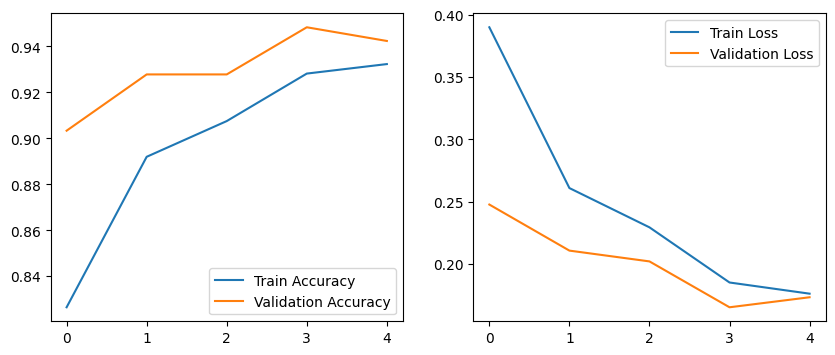

In [13]:
#plot Accuracy and Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1) #1 row,2 columns,first subplot
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.subplot(1,2,2)#1 row,2 columns,second subplot
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


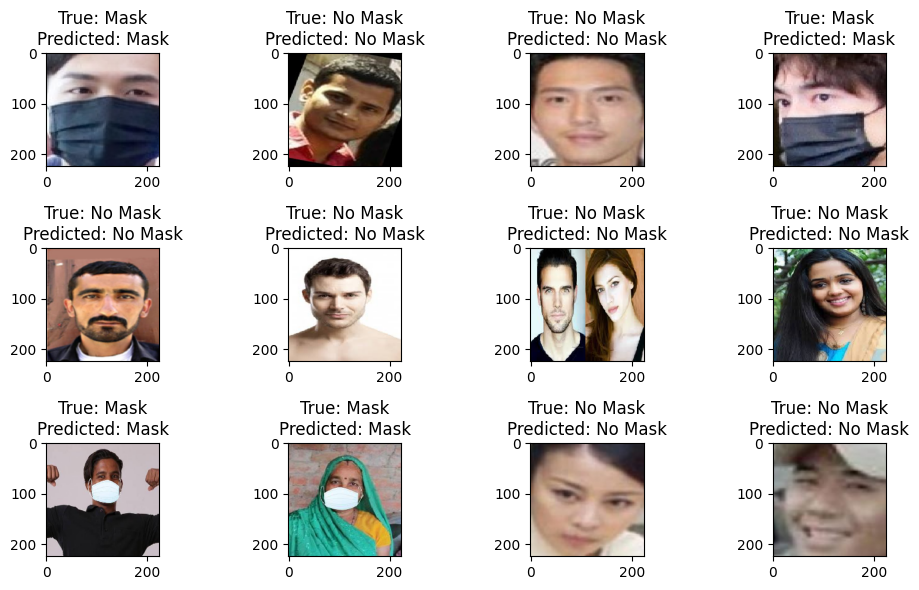

In [16]:
# next() function gets one batch of data from it.
#images → a batch of 32 images (since batch_size=32 earlier)
#labels → their corresponding true class labels (0 or 1)

images,labels=next(test_data)

predictions=model.predict(images)
plt.figure(figsize=(10,6))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(images[i])
    #Values < 0.5 → class 0 (No Mask)
    #Values ≥ 0.5 → class 1 (Mask)
    true_label="Mask" if labels[i]==0 else "No Mask"
    predicted_label="Mask" if predictions[i]<0.5 else "No Mask"
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Saving nd.webp to nd (1).webp
File Uploaded :  nd (1).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction :  No Mask
Confidence :  96.71706 %


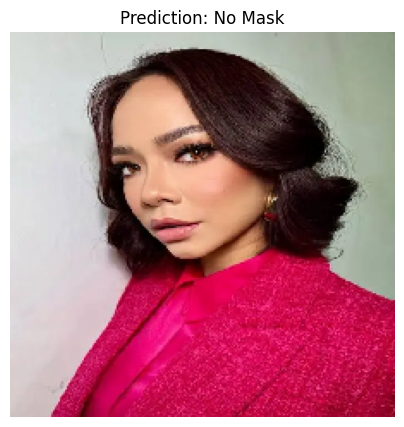

In [19]:
from google.colab import files
uploaded=files.upload()

for fn in  uploaded.keys():
  img_path=fn
  print("File Uploaded : ",img_path)
  img=image.load_img(img_path,target_size=(224,224))
  img_array=image.img_to_array(img) #convert to numeric array

  #Model learned to expect input with 4 dimensions.
  #Keras models always expect a batch
  #Load one image, which have 3 array
  #Need to expend dimension to a batch of 1 image, (224, 224, 3)  →  (1, 224, 224, 3). 1 is the image
  img_array=np.expand_dims(img_array,axis=0)/255.0

  pred=model.predict(img_array)[0][0]
  label="Mask " if pred<0.5 else "No Mask"
  print("Prediction : ",label)
  print("Confidence : ",100*(1-pred) if pred<0.5 else 100*pred,"%")

  plt.figure(figsize=(5,5))
  plt.imshow(img)
  plt.title(f"Prediction: {label}")
  plt.axis("off")
  plt.show()